# **DinoResNet-Vertical Model**
The Vertical Model is an innovative approach that synergizes the capabilities of a Vision Transformer (ViT-S variant) with a custom ResNet-50 architecture. This design integrates the process of global feature extraction by the ViT-S with the subsequent in-depth local feature analysis by the ResNet-50.
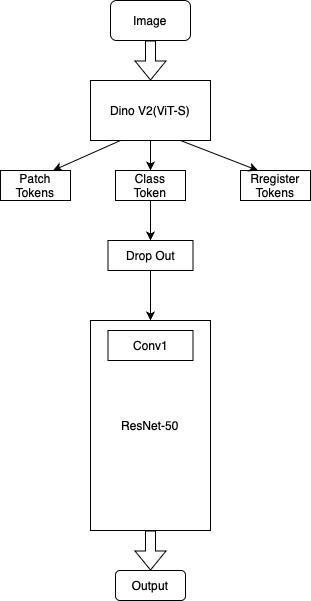

## **Load the Datasets via Huggingface**

**Install huggingface_hub to load the stream dataset.**

In [ ]:
!pip install --upgrade huggingface_hub
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.2 MB/s eta 0:00:00


**Logging in huggingface with token. Please change $HUGGINGFACE_TOKEN with your own token.**

In [ ]:
!huggingface-cli login --token $HUGGINGFACE_TOKEN

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


**Mounted at Google Drive to store the .pth file.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Import the necessary libraries**

In [ ]:
import random
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms, models
from torchvision.models import resnet50
from torch.utils.data import DataLoader
from torch.utils.data import IterableDataset
import torch.utils.data as data
from torchvision.transforms import Grayscale
from datasets import load_dataset
from tqdm import tqdm
import random

## **Streaming Dataset Handling and Image Transformations**

***StreamingImageNetDataset:*** This custom dataset class is designed to handle the ImageNet dataset in a streaming manner. It's particularly useful when working with large datasets that cannot be loaded entirely into memory.

This class employs a buffering mechanism that simulates the traditional data shuffling method found in standard datasets. By dynamically loading and shuffling data in memory through this buffer, it ensures both efficient memory usage and randomness in data presentation during training and it help reducing model overfitting and improving generalization.

***Image Transformations:*** Two distinct transformation pipelines are set up:

*train_transforms:* This is a comprehensive set of image augmentations for the training set, including resizing, random flips, rotations, color jitters, and more. These augmentations introduce variations in the training data, which is vital to prevent overfitting and improve the model's ability to generalize.

*data_transforms:* Less aggressive transformations for validation and test datasets, focusing on resizing, cropping, and normalization. This ensures that the evaluation datasets undergo minimal alterations, reflecting more realistic conditions.

In [ ]:
class StreamingImageNetDataset(IterableDataset):
    def __init__(self, dset_stream, transform=None, limit=None, start=0, buffer_size=10000):
        super(StreamingImageNetDataset, self).__init__()
        self.dset_stream = dset_stream
        self.transform = transform
        self.limit = limit
        self.start = start
        self.buffer_size = buffer_size
        self.buffer = []

    def fill_buffer(self):
        self.buffer = []
        stream_iter = iter(self.dset_stream)
        for _ in range(self.buffer_size):
            try:
                item = next(stream_iter)
                image, label = self.process(item)
                if image is not None and label is not None:
                    self.buffer.append((image, label))
            except StopIteration:
                break

    def __iter__(self):
        if not self.buffer:
            self.fill_buffer()
        count = 0
        stream_iter = iter(self.dset_stream)
        while count < self.limit:
            if len(self.buffer) == 0:
                break
            # Randomly sample from the buffer
            idx = random.randint(0, len(self.buffer) - 1)
            yield self.buffer[idx]
            count += 1
            # Try to replace the sampled element with a new one from the stream
            try:
                item = next(stream_iter)
                image, label = self.process(item)
                if image is not None and label is not None:
                    self.buffer[idx] = (image, label)
            except StopIteration:
                # If no more data, remove the used item
                self.buffer.pop(idx)

    def process(self, item):
        image, label = item['image'], item['label']

        if label < 0 or label > 999:
            print(f'Invalid label: {label}')
            return None, None

        if self.transform:
            image = self.transform(image)

        return image, label

    def set_transform(self, new_transform):
        self.transform = new_transform

def convert_to_rgb(image):
    """ Convert a PIL Image to RGB """
    return image.convert('RGB')

train_transforms = transforms.Compose([
    transforms.Lambda(convert_to_rgb),
    transforms.Resize(256),  # Resize the image to 256x256 pixels
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomVerticalFlip(),  # Randomly flip the image vertically
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.RandomPosterize(bits=4),  # Randomly posterize the image
    transforms.RandomAdjustSharpness(sharpness_factor=2),  # Randomly adjust the sharpness
    transforms.RandomAutocontrast(),  # Automatically adjust the image contrast
    transforms.RandomEqualize(),  # Equalize the image histogram
    transforms.CenterCrop(224),  # Crop the center of the image to 224x224
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

data_transforms = transforms.Compose([
    transforms.Lambda(convert_to_rgb),
    transforms.Resize(256),  # Resize the image to 256x256 pixels
    transforms.CenterCrop(224),  # Crop the center of the image to 224x224
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

## **Model**

***CustomResNet50:*** This class customizes the standard ResNet-50 model. It begins with a fully connected layer (initial_fc) designed to reshape the input feature vector (with an expected size of 384, matching the output of the ViT) to a 224x224 size, which aligns with the input requirement of the ResNet-50. The ResNet-50 model is then loaded with pretrained weights (IMAGENET1K_V1) for enhanced feature extraction capabilities. The first convolutional layer (conv1) of the ResNet-50 is modified to accept single-channel input, which is typical for transformer outputs.

***ModifiedDinoVisionTransformer:*** This class represents a modified version of the DINO Vision Transformer. It loads the pretrained dinov2_vits14 model from the Facebook Research Hub. The forward pass of the model extracts the class token from the transformer's output. This class token is a compact representation of the global features learned by the ViT.

***DinoVisionTransformerClassifier:*** This top-level class combines the two previous components. The ModifiedDinoVisionTransformer processes the input image first, extracting the class token which encapsulates the global contextual information of the image. This class token is then passed through a dropout layer for regularization, followed by the CustomResNet50 for further processing. The ResNet-50 model, with its convolutional layers, focuses on extracting local features and textures. The output of this model is the final classification result, benefiting from both the global context provided by the ViT and the detailed local feature extraction capabilities of the ResNet-50.

In [ ]:
class CustomResNet50(nn.Module):
    def __init__(self):
        super(CustomResNet50, self).__init__()
        self.initial_fc = nn.Linear(384, 50176)  # 示例尺寸：224 * 224

        self.resnet = models.resnet50(weights='IMAGENET1K_V1')
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)


    def forward(self, x):
        x = self.initial_fc(x)
        x = x.view(-1, 1, 224, 224)

        return self.resnet(x)

class ModifiedDinoVisionTransformer(nn.Module):
    def __init__(self):
        super(ModifiedDinoVisionTransformer, self).__init__()
        self.dino_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')

    # Create a normalization layer for the transformer if needed
        trans_layer_norm = nn.LayerNorm(normalized_shape=(384,), eps=1e-6)  # Replace '...' with the correct normalized shape

    def forward(self, x):
        outputs = self.dino_model.forward_features(x)

        class_token = outputs.get('x_norm_clstoken', None)
        # patch_embeddings = outputs.get('x_norm_patchtokens', None)

        # Check if the required outputs are present
        # if class_token is None or patch_embeddings is None:
        if class_token is None:
            raise ValueError("Required output keys not found in model outputs")

        # return class_token, patch_embeddings
        return class_token

class DinoVisionTransformerClassifier(nn.Module):
    def __init__(self):
        super(DinoVisionTransformerClassifier, self).__init__()
        self.transformer = ModifiedDinoVisionTransformer()
        self.resnet = CustomResNet50()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.transformer(x)
        x = self.dropout(x)
        x = self.resnet(x)
        return x

## **Train and Evaluate Function**

In [ ]:
def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    num_batches = 0

    model.train()

    for (x, y) in iterator:
        num_batches += 1

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()

        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()

    epoch_loss /= num_batches
    epoch_acc_1 /= num_batches
    epoch_acc_5 /= num_batches

    return epoch_loss, epoch_acc_1, epoch_acc_5

def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    num_batches = 0

    model.eval()

    with torch.no_grad():
        for (x, y) in iterator:
            num_batches += 1

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)
            loss = criterion(y_pred, y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()

    epoch_loss /= num_batches
    epoch_acc_1 /= num_batches
    epoch_acc_5 /= num_batches

    return epoch_loss, epoch_acc_1, epoch_acc_5

def calculate_topk_accuracy(y_pred, y, k = 5):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k

## **Main Function**


1.   Load the datasets and model
2.   Setting for hyperparameter
3.   Train the model
4.   Evaluation for the result

In [ ]:
if __name__ == '__main__':
    # Set the random seeds for reproducibility
    SEED = 1234

    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True

    # Load the datasets
    BATCH_SIZE = 128

    train_dataset_stream = load_dataset('imagenet-1k', split='train', streaming=True, use_auth_token=True)
    train_dataset = StreamingImageNetDataset(train_dataset_stream, transform=train_transforms, limit=100000)
    # train_iterator = data.DataLoader(train_dataset, batch_size=BATCH_SIZE)

    validation_dataset_stream = load_dataset('imagenet-1k', split='validation', streaming=True, use_auth_token=True)
    validation_dataset = StreamingImageNetDataset(validation_dataset_stream, transform=data_transforms, limit=10000, start=0)
    # validation_iterator = data.DataLoader(validation_dataset, batch_size=BATCH_SIZE)

    test_dataset_stream = load_dataset('imagenet-1k', split='validation', streaming=True, use_auth_token=True)
    test_dataset = StreamingImageNetDataset(test_dataset_stream, transform=data_transforms, limit=20000, start=10000)
    test_iterator = data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

    # Load the DinoResNet model
    model = DinoVisionTransformerClassifier()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
    device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    criterion = criterion.to(device)
    print('---------------------------')
    print(model)
    print('---------------------------')

    # Train the model
    print('Training the model:')
    EPOCHS = 10

    for epoch in range(EPOCHS):
      train_dataset.fill_buffer()
      validation_dataset.fill_buffer()
      train_iterator = data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
      validation_iterator = data.DataLoader(validation_dataset, batch_size=BATCH_SIZE)
      train_loss, train_acc_1, train_acc_5 = train(model, train_iterator, optimizer, criterion, device)
      val_loss, val_acc_1, val_acc_5 = evaluate(model, validation_iterator, criterion, device)

      # Print the output of train and validation
      print(f'Epoch: {epoch+1:02}')
      print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | Train Acc @5: {train_acc_5*100:6.2f}%')
      print(f'\t Val. Loss: {val_loss:.3f} |  Val. Acc @1: {val_acc_1*100:6.2f}% |  Val. Acc @5: {val_acc_5*100:6.2f}%')

    # Save the DinoResNet model
    model_save_name = 'DinoResNet.pth'
    path = F"/content/drive/My Drive/{model_save_name}"
    torch.save(model.state_dict(), path)

    # Evaluate the model
    test_loss, test_acc_1, test_acc_5 = evaluate(model, test_iterator, criterion, device)

    # Print the output
    print('---------------------------')
    print('Evaluating the model:')
    print(f'Test Loss: {test_loss:.3f} | Test Acc @1: {test_acc_1*100:6.2f}% | 'f'Test Acc @5: {test_acc_5*100:6.2f}%')
    print('---------------------------')

/usr/local/lib/python3.10/dist-packages/datasets/load.py:2088: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/datasets/load.py:2088: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(
Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dino

---------------------------
DinoVisionTransformerClassifier(
  (transformer): ModifiedDinoVisionTransformer(
    (dino_model): DinoVisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
        (norm): Identity()
      )
      (blocks): ModuleList(
        (0-11): 12 x NestedTensorBlock(
          (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
          (attn): MemEffAttention(
            (qkv): Linear(in_features=384, out_features=1152, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=384, out_features=384, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): LayerScale()
          (drop_path1): Identity()
          (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=384, out_features=1536, bias=True)
            (act): GELU(approximate